### Copy and Rename last state and weight from simulations

In [1]:
import glob
import shutil
import os

#list up folders in simulation
folders = sorted(glob.glob("./quantum/*_Zone-*/"))
print(f'There are {len(folders)} folders.')

#get last states and weights
for folder in folders:
    try:
        fns = sorted(glob.glob(folder+'state*/sim*100.csv'))[-1]
        fnw = sorted(glob.glob(folder+'weights/*.csv'))[-1]
    except:
        print(f'SKIPPED: {fns}')
        print('---')
        continue
    
    #get case as strings
    zone = fns.split('-')[1]
    eta = fns.split('-')[2]
    evac = fns.split('/s')[0].split('-')[-1] #fns.split('_')[3]
    if eta == 'mssd':
        print(f'SKIPPED: {fns}')
        print('---')
        continue
    else:
        print(f'Case: Zone {zone} - ETA {eta} - EVAC {evac}')
    
    #copy files
    dfs = './database/states'
    dfw = './database/weights'
    shutil.copy(fns,dfs)
    shutil.copy(fnw,dfw)
    
    #rename files
    file_name = fns.split('/')[-1]
    try:
        os.rename(f'./database/states/{file_name}',f'./database/states/z{zone}_eta{eta}_evac{evac}_{file_name}')
    except:
        pass
    
    file_name = fnw.split('/')[-1]
    try:
        os.rename(f'./database/weights/{file_name}',f'./database/weights/z{zone}_eta{eta}_evac{evac}_{file_name}')
    except:
        pass
    print('---')


There are 116 folders.
Case: Zone 1 - ETA 15 - EVAC 5
---
Case: Zone 1 - ETA 15 - EVAC 10
---
Case: Zone 1 - ETA 30 - EVAC 5
---
Case: Zone 1 - ETA 30 - EVAC 10
---
Case: Zone 1 - ETA 30 - EVAC 15
---
Case: Zone 1 - ETA 30 - EVAC 20
---
Case: Zone 1 - ETA 30 - EVAC 25
---
Case: Zone 1 - ETA 60 - EVAC 5
---
Case: Zone 1 - ETA 60 - EVAC 10
---
Case: Zone 1 - ETA 60 - EVAC 15
---
Case: Zone 1 - ETA 60 - EVAC 20
---
Case: Zone 1 - ETA 60 - EVAC 25
---
Case: Zone 1 - ETA 60 - EVAC 30
---
Case: Zone 1 - ETA 60 - EVAC 35
---
Case: Zone 1 - ETA 60 - EVAC 40
---
Case: Zone 1 - ETA 60 - EVAC 45
---
Case: Zone 1 - ETA 60 - EVAC 50
---
Case: Zone 1 - ETA 60 - EVAC 55
---
Case: Zone 1 - ETA 60 - EVAC 1
---
Case: Zone 1 - ETA 30 - EVAC 1
---
Case: Zone 1 - ETA 15 - EVAC 1
---
SKIPPED: ./quantum/1670287303382_Zone-1-mssd-c0-15-10/state_15_10_100/sim_000000100.csv
---
SKIPPED: ./quantum/1670288167693_Zone-1-mssd-c6-15-10/state_15_10_100/sim_000000100.csv
---
SKIPPED: ./quantum/1670288280195_Zone-1-mss

### Move video files to corresponding folder

In [2]:
import glob
import shutil

#move videos to corresponding folder
videos = sorted(glob.glob('./quantum/*.mp4'))
for video in videos:
    vf = video.split('_sim')[0]
    shutil.move(video,f'{vf}/.')

### Matching of case by looking at population distribution

In [1]:
#The real-time data needs to be dissagregated to points, then re-aggregated as a mesh (geojson)
#export the geojson to tiff?
#compare

#imports
import pandas as pd
import numpy as np
import geopandas as gpd
import glob

#1. Real-time data
mssds = glob.glob("/Volumes/Pegasus32/kochi/zones/zone01/*mssd*.geojson") #all available
mesh = gpd.read_file(mssds[0]) #one case - let say is the current pop distribution
meshp = mesh.to_crs(6690)
#!==> Need to disaggregate and re-aggregate this one

#2. Database zone 1
db_mss = sorted(glob.glob('./quantum/*Zone-1-mssd*/results/agents_startcondition.csv')) #a list
db_cen = sorted(glob.glob('./quantum/*/results/agents_startcondition.csv'))[0] #one string

def aggregate_points_to_mesh(point_file:str,crs:int):
    df = pd.read_csv(point_file,header=None,names=['lon','lat'],usecols=[0,1])
    gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(x=df['lon'],y=df['lat']),crs=crs)
    gdf['value']=[1]*gdf.shape[0]
    gdf['column']=['agents']*gdf.shape[0]
    #Join
    dfsjoin = gpd.sjoin(gdf,meshp) #Spatial join Points to polygons
    #Aggregate
    dfpivot = pd.pivot_table(dfsjoin,values='value',columns=['column'],
                            index='MESH4_ID',aggfunc=np.sum,dropna=False,fill_value=0)
    dfpolynew = meshp.merge(dfpivot, how='left', on='MESH4_ID',)
    dfpolynew.plot(column='agents',cmap='viridis',missing_kwds= dict(color = "lightgrey"))  
    return dfpolynew





(array([5398., 2667., 3042., 1662., 1771., 2698., 2863., 1117.,  947.,
         781.]),
 array([   0. ,  273.2,  546.4,  819.6, 1092.8, 1366. , 1639.2, 1912.4,
        2185.6, 2458.8, 2732. ]),
 <BarContainer object of 10 artists>)

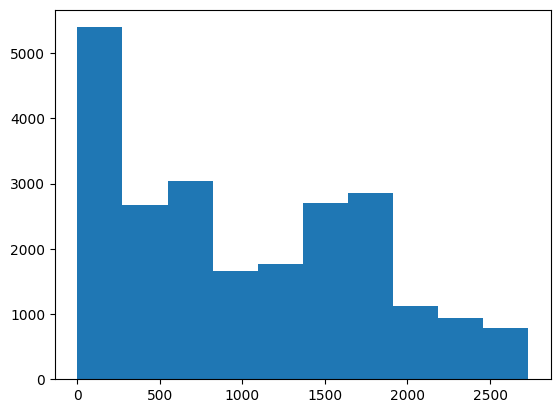

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt

CASE_FOLDER = "case"
POPULATION_FILE = mssds[0] #path string to a MSS mesh data - geojson
POPULATION_FIELDNAME_IN_FILE = 'population'
PJ_CRS = 6690

def create_folder(dirname):
    Path(dirname).mkdir(parents=True, exist_ok=True)
    
def pointsWithinPolygon(poly):
    # Get the nodes within a polygon
    df = pd.read_csv(Path(CASE_FOLDER, "nodesdb.csv"))
    nodes = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.coord_x, df.coord_y), crs=PJ_CRS
    )
    gs = gpd.GeoSeries(nodes.geometry)
    ninarea = nodes[gs.within(poly)]
    return ninarea

# Create the agentsdb
def appendAgents(agentsdb, pop, index, poly):
    # Get a polygon
    poly_pop = pop[POPULATION_FIELDNAME_IN_FILE].to_list()[index]
    ninarea = pointsWithinPolygon(poly)
    if ninarea.shape[0] == 0:
        return agentsdb
    pop_per_node = int(poly_pop / ninarea.shape[0])
    from_row = np.trim_zeros(agentsdb[:, 4], "b").shape[0]
    to_row = from_row + ninarea.shape[0] * pop_per_node  # +1?
    n = ninarea["# number"].to_list()
    nr = np.repeat(n, pop_per_node)
    agentsdb[from_row:to_row, 4] = nr
    return agentsdb

#===============

create_folder(dirname=CASE_FOLDER)
pop = gpd.read_file(POPULATION_FILE)
pop_pj = pop.to_crs(PJ_CRS)

agentsdb = np.zeros((int(pop[POPULATION_FIELDNAME_IN_FILE].sum()), 5))
for i, g in enumerate(pop_pj.geometry.to_list()):
    agentsdb = appendAgents(agentsdb, pop=pop_pj, index=i, poly=g)
last = np.trim_zeros(agentsdb[:, 4], "b").shape[0]
agentsdb = agentsdb[:last, :]
np.savetxt(
    Path(CASE_FOLDER, "agentsdb.csv"),
    agentsdb,
    delimiter=",",
    header="age,gender,hhType,hhId,Node",
    fmt="%d,%d,%d,%d,%d",
)

plt.hist(agentsdb[:,4])


In [10]:
#after dissagreggation we have 'agentsdb_gt'x1 (ground truth) - 'agentsdb_db'xN
#compare and match
from scipy.stats import pearsonr 

agentsdb_gt = agentsdb[:,4].copy() #numpy of 1D
filenames = glob.glob('./quantum/*_Zone-1*/data/agentsdb.csv')
max = -1000
pos = None
for i, filename in enumerate(filenames):
    agentsdb_db = np.loadtxt(filename,delimiter=",", usecols=4, dtype=np.int16)
    if agentsdb_gt.shape[0] < agentsdb_db.shape[0]:
        agentsdb_db = agentsdb_db[:agentsdb_gt.shape[0]].copy()
    else:
        agentsdb_gt = agentsdb_gt[:agentsdb_db.shape[0]].copy()
    # sim_index = np.corrcoef(agentsdb_gt,agentsdb_db).sum()
    sim_index = pearsonr(agentsdb_gt,agentsdb_db).statistic
    if max < sim_index:
        pos = i
        max = sim_index
        
print(f'{pos} : {filenames[pos]}')
print(f'Similarity Index = {max}')
    

6 : ./quantum/1678109375875_Zone-1-mssd-c0-15-1/data/agentsdb.csv
Similarity Index = 1.0


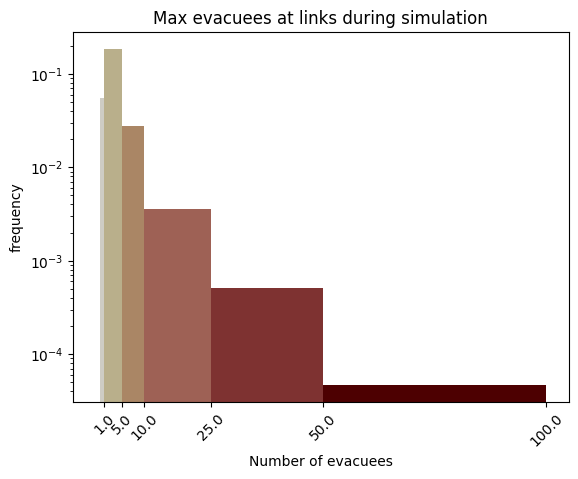

In [53]:
import cmcrameri.cm as cmc
import random
import string

accw = np.loadtxt('./acc_weight_Zone-1-60-20.csv',skiprows=1,delimiter=',',usecols=1)
N, bins, patches = plt.hist(accw,bins=[-1, 0, 1, 5, 10, 25, 50, 100],log=True,density=True)
# Random facecolor for each bar
color = cmc.bilbao(np.linspace(0,1,len(N)))
for i in range(len(N)):
   patches[i].set_facecolor(color[i])
plt.title('Max evacuees at links during simulation')
plt.xlabel('Number of evacuees')
plt.ylabel('frequency')
plt.xticks(ticks=bins[2:],labels=bins[2:],rotation=45);
   


### Plot cases

<Axes: >

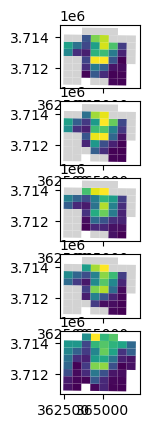

In [3]:
#Convert database of population to 500m grid
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import glob

breakat = 4 #len(files)
files = sorted(glob.glob('./quantum/*mssd*/results/agents_startcondition.csv'))
remain = len(files)-breakat
fig, axs = plt.subplots(breakat+1,1)
#get a mesh of the area
mssds = glob.glob("/Volumes/Pegasus32/kochi/zones/zone01/*mssd*.geojson")
mesh = gpd.read_file(mssds[0])
meshp = mesh.to_crs(6690)
for i,file in enumerate(files):
    if i == breakat:
        break
    df = pd.read_csv(file,header=None,names=['lon','lat'],usecols=[0,1])
    gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(x=df['lon'],y=df['lat']),crs=6690)
    gdf['value']=[1]*gdf.shape[0]
    gdf['column']=['agents']*gdf.shape[0]
    #Join
    dfsjoin = gpd.sjoin(gdf,meshp) #Spatial join Points to polygons
    #Aggregate
    dfpivot = pd.pivot_table(dfsjoin,values='value',columns=['column'],
                            index='MESH4_ID',aggfunc=np.sum,dropna=False,fill_value=0)
    dfpolynew = meshp.merge(dfpivot, how='left', on='MESH4_ID',)  
    dfpolynew.plot(ax=axs[i],column='agents',cmap='viridis',missing_kwds= dict(color = "lightgrey"))
meshp.plot(ax=axs[breakat],column='population',cmap='viridis',missing_kwds= dict(color = "lightgrey"))

<AxesSubplot: >

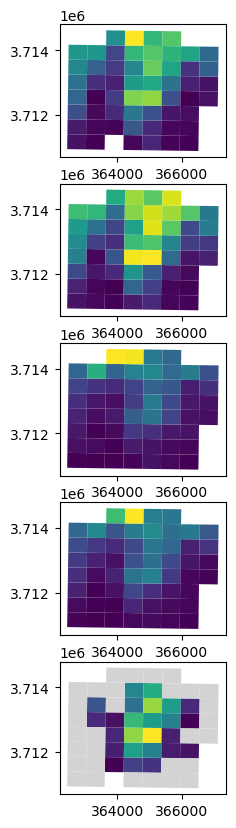

In [88]:
import matplotlib.pyplot as plt
import glob

mssds = glob.glob("/Volumes/Pegasus32/kochi/zones/zone01/*mssd*.geojson")
fig, axs = plt.subplots(len(mssds)+1,1,figsize=(50,10))
for i, mss in enumerate(mssds):
    mesh = gpd.read_file(mss)
    meshp = mesh.to_crs(6690)
    meshp.plot(ax=axs[i],column='population',cmap='viridis',missing_kwds= dict(color = "lightgrey"))
dfpolynew.plot(ax=axs[len(mssds)],column='agents',cmap='viridis',missing_kwds= dict(color = "lightgrey"))

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import glob

#1. Real-time data
mssds = glob.glob("/Volumes/Pegasus32/kochi/zones/zone01/*mssd*.geojson")
mesh = gpd.read_file(mssds[0])
meshp = mesh.to_crs(6690)

In [2]:
meshp.explore()

## Find the highest case of weights

In [ ]:
import glob
import pandas as pd
import numpy as np

cases = sorted(glob.glob('quantum/*_Zone-1-60-20/weights/*.csv'))

In [ ]:
df = pd.read_csv(cases[0],names=['link','weight'])
w = np.zeros((df.shape[0],2),dtype=np.int16)
w[:,0]=df.link

In [ ]:
for case in cases[1:]:
    df = pd.read_csv(case,names=['link','weight'])
    for i in range(df.shape[0]):
        if w[i,1] < df['weight'].iloc[i]:
            w[i,1] = df['weight'].iloc[i]

In [ ]:
wdf = pd.DataFrame(w,columns=['link','weight'])
wdf.head()

,link,weight
0,0,4
1,1,4
2,2,2
3,3,9
4,4,2


In [ ]:
bins = [-1, 0, 1, 5, 10, 25, 50, 100]
s = wdf.groupby(pd.cut(wdf['weight'], bins=bins)).size()
print (s)

weight
(-1, 0]       190
(0, 1]        816
(1, 5]       1871
(5, 10]       346
(10, 25]      155
(25, 50]       40
(50, 100]       7
dtype: int64


In [ ]:
wdf.to_csv('acc_weight_Zone-1-60-20.csv',index=False)

#### Previous tests (not important)

In [57]:
import glob
import pandas as pd

cases = sorted(glob.glob('quantum/*_Zone-*-60-*/weights/*3591.csv'))

In [58]:
bins = [-1, 0, 1, 5, 10, 25, 50, 100]
s_min = 10000
case_min = None
for case in cases:
    df = pd.read_csv(case,names=['node','weight'])
    s = df.groupby(pd.cut(df['weight'], bins=bins)).size()
    if s[0] < s_min:
        s_min = s[0]
        case_min = case
print(s_min,case_min)

2695 quantum/1669945931031_Zone-1-60-55/weights/w_100_000003591.csv


1287 quantum/1678014524343_Zone-5-15-1/weights/w_100_000000891.csv  
2386 quantum/1669906262746_Zone-1-30-25/weights/w_100_000001791.csv  
2695 quantum/1669945931031_Zone-1-60-55/weights/w_100_000003591.csv

In [ ]:
bins = [-1, 0, 1, 5, 10, 25, 50, 100]
s_min = 10000
case_min = None
for case in cases:
    df = pd.read_csv(case,names=['node','weight'])
    s = df.groupby(pd.cut(df['weight'], bins=bins)).size()
    if s[0] < s_min:
        s_min = s[0]
        case_min = case
print(s_min,case_min)

2695 quantum/1669945931031_Zone-1-60-55/weights/w_100_000003591.csv


In [35]:
import glob
import pandas as pd

files15 = sorted(glob.glob('quantum/1669905841775_Zone-1-15-10/weights/*.csv'))
files60 = sorted(glob.glob('quantum/1669945424256_Zone-1-60-20/weights/*.csv'))
file15_5 = sorted(glob.glob('quantum/1669905766116_Zone-1-15-5/weights/*.csv'))

In [27]:
df15 = pd.read_csv(files15[-1],names=['node','weight'])
df15.head()

,node,weight
0,0,1
1,1,4
2,2,1
3,3,0
4,4,0


In [28]:
df60 = pd.read_csv(files60[-1],names=['node','weight'])
df60.head()

,node,weight
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [36]:
df15_5 = pd.read_csv(file15_5[-1],names=['node','weight'])
df15_5.head()

,node,weight
0,0,10
1,1,0
2,2,0
3,3,0
4,4,0


In [31]:
bins = [-1, 0, 1, 5, 10, 25, 50, 100]
s15 = df15.groupby(pd.cut(df15['weight'], bins=bins)).size()
print (s15)

weight
(-1, 0]      2045
(0, 1]        572
(1, 5]        506
(5, 10]       154
(10, 25]       93
(25, 50]       41
(50, 100]      13
dtype: int64


In [46]:
s15[0]

2045

In [32]:
bins = [-1, 0, 1, 5, 10, 25, 50, 100]
s60 = df60.groupby(pd.cut(df60['weight'], bins=bins)).size()
print (s60)

weight
(-1, 0]      3358
(0, 1]         34
(1, 5]         13
(5, 10]        10
(10, 25]       10
(25, 50]        1
(50, 100]       0
dtype: int64


In [37]:
bins = [-1, 0, 1, 5, 10, 25, 50, 100]
s15_5 = df15_5.groupby(pd.cut(df15_5['weight'], bins=bins)).size()
print (s15_5)

weight
(-1, 0]      2972
(0, 1]        188
(1, 5]        149
(5, 10]        45
(10, 25]       48
(25, 50]       15
(50, 100]       6
dtype: int64


<AxesSubplot: xlabel='weight'>

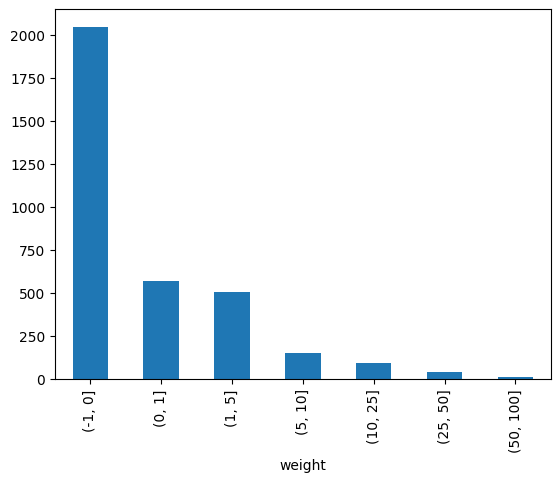

In [33]:
s15.plot(kind='bar')

<AxesSubplot: xlabel='weight'>

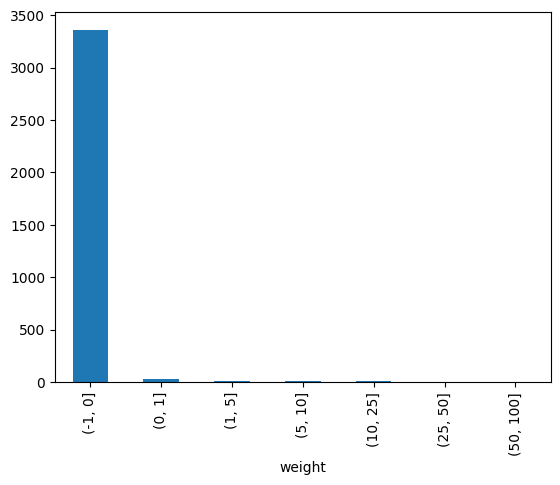

In [34]:
s60.plot(kind='bar')

<AxesSubplot: xlabel='weight'>

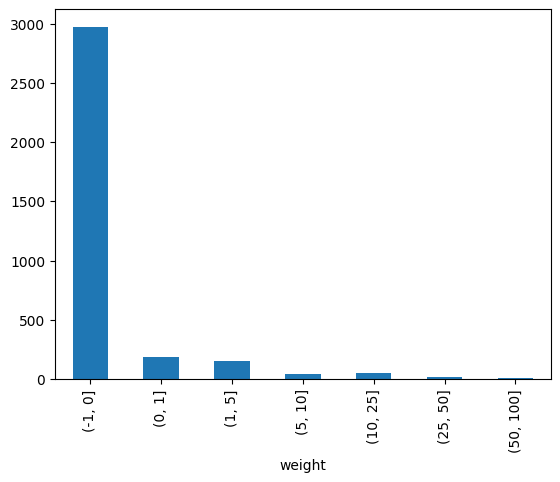

In [38]:
s15_5.plot(kind='bar')